In [1]:
!neofetch

        #####
       #######
       ##O#O##
       #######
     ###########
    #############
   ###############
   ################
  #################
#####################
#####################
  #################
root@pynq 
--------- 
OS: PynqLinux, based on Ubuntu 22.04 armv7l 
Host: Digilent Zybo board (BSUIR EVS) 
Kernel: 5.15.19-xilinx-v2022.1 
Uptime: 22 mins 
Packages: 1661 (dpkg) 
Shell: bash 5.1.16 
Terminal: jupyter-noteboo 
CPU: Xilinx Zynq Platform (2) 
Memory: 78MiB / 493MiB 

                        
                        




In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Время (секунды)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Входной сигнал')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=2,label='Сигнал после Fir фильтрации')
    plt.legend()

Число отсчетов:  16000


<IPython.core.display.Javascript object>


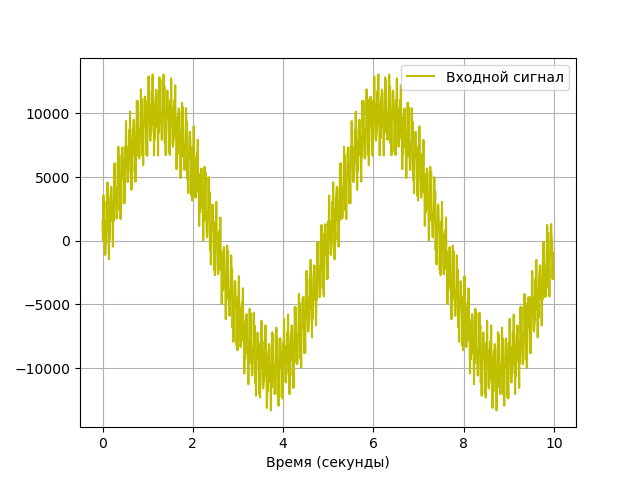

In [3]:
import numpy as np

# Total time
T = 0.00016 #Problem with buffer size above 16K???
# Sampling frequency
fs = 100e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Samples of the signal
samples = 10000*np.sin(0.2e6*2*np.pi*t) + 1500*np.cos(46e6*2*np.pi*t) + 2000*np.sin(12e6*2*np.pi*t)
# Convert samples to 32-bit integers
samples = samples.astype(np.int32)
print('Число отсчетов: ',len(samples))

# Plot signal to the notebook
plot_to_notebook(t,samples,1000)

Время программного выполнения Fir:  0.00882720947265625


<IPython.core.display.Javascript object>


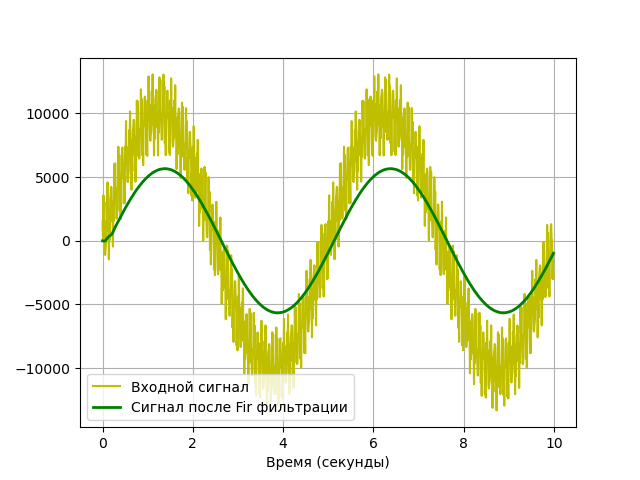

In [4]:
from scipy.signal import lfilter

coeffs = [-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]

import time
start_time = time.time()
sw_fir_output = lfilter(coeffs,70e3,samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Время программного выполнения Fir: ',sw_exec_time)

# Plot the result to notebook
plot_to_notebook(t,samples,1000,out_signal=sw_fir_output)

In [5]:
!ls -l

total 3348
-rw-r--r-- 1 root root  514591 Jun  2 21:37 filter.ipynb
-rw-r--r-- 1 root root 2083852 Jun  2 20:42 fir_filter_test.bit
-rw-r--r-- 1 root root  318965 Jun  2 20:48 fir_filter_test.hwh
-rw-r--r-- 1 root root   46483 Jun  2 20:42 fir_filter_test.tcl
-rw-r--r-- 1 root root  458704 Jun  2 20:42 fir_filter_test.xsa


my hwh ```home/vbox/filter_test/project_fir/project_fir.gen/sources_1/bd/design_1/hw_handoff/design_1.hwh```

In [6]:
from pynq import Overlay
import numpy as np
# Load the overlay
overlay = Overlay('/home/xilinx/jupyter_notebooks/my_filter/fir_filter_test.xsa')
help(overlay)

Help on Overlay in module pynq.overlay:

<pynq.overlay.Overlay object>
    Default documentation for overlay /home/xilinx/jupyter_notebooks/my_filter/fir_filter_test.xsa. The following
    attributes are available on this overlay:
    
    IP Blocks
    ----------
    filter/fir_dma       : pynq.lib.dma.DMA
    processing_system7_0 : pynq.overlay.DefaultIP
    
    Hierarchies
    -----------
    filter               : pynq.overlay.DefaultHierarchy
    
    Interrupts
    ----------
    None
    
    GPIO Outputs
    ------------
    None
    
    Memories
    ------------
    PSDDR                : Memory



<IPython.core.display.Javascript object>


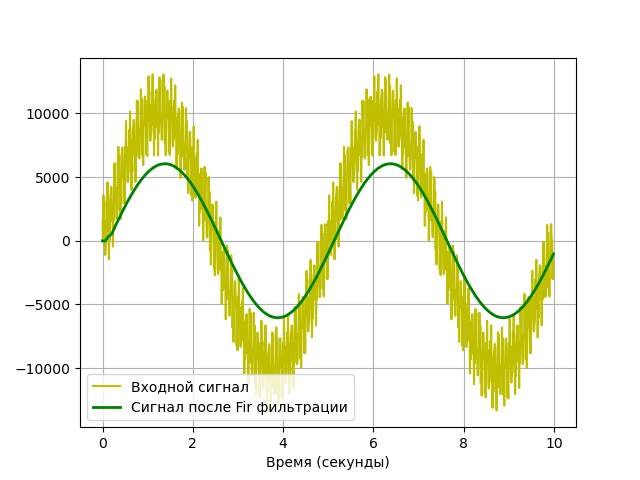

Время аппаратного выполнения Fir:  0.0039157867431640625
Коэффициент аппаратного ускорения:  2.254262055528495


In [7]:
import time
from pynq import allocate
n = len(samples)
# буферы для DMA
in_buffer = allocate(shape=(n,), dtype=np.int32)
out_buffer = allocate(shape=(n,), dtype=np.int32)

# Копируем сигнал во входной буфер
in_buffer[:] = samples

# Запускаем передачу через DMA
start_time = time.time()
fir_dma = overlay.filter.fir_dma
fir_dma.sendchannel.transfer(in_buffer)
fir_dma.recvchannel.transfer(out_buffer)
stop_time = time.time()

fir_dma.sendchannel.wait()
fir_dma.recvchannel.wait()

# Теперь out_buffer содержит фильтрованный сигнал
filtered_signal = out_buffer.copy()
#print(filtered_signal)
plot_to_notebook(t,samples,1000,filtered_signal)
hw_exec_time = stop_time - start_time
print('Время аппаратного выполнения Fir: ', hw_exec_time )
print('Коэффициент аппаратного ускорения: ',sw_exec_time / hw_exec_time)

Python-путь (allocate + sendchannel/recvchannel) всегда чуть медленнее, чем “низкоуровневый” подход через специализированные библиотеки.

#### Что делает стандартный PYNQ путь с allocate и send/recvchannel?
Он более универсальный: через Python-обертки, доп. проверки, создание Python-буферов, возможно, копирование в numpy-объекты и обратно, вызовы драйверов через CFFI.

---
### Обращение к регистрам DMA напрямую, полностью без pynq.lib.dma.

Время аппаратного выполнения FIR: 0.001735687255859375
Коэффициент аппаратного ускорения: 5.085714285714285


<IPython.core.display.Javascript object>


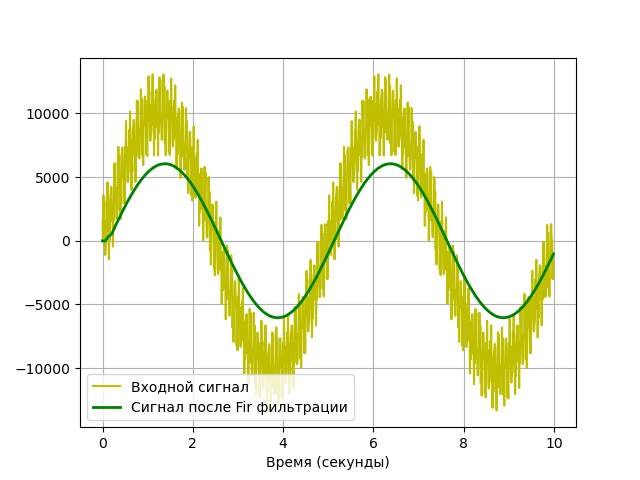

In [8]:
from pynq import Overlay, allocate
import numpy as np
import mmap, os, struct, time

# Загружаем overlay
overlay = Overlay('/home/xilinx/jupyter_notebooks/my_filter/fir_filter_test.xsa')

# Подготовим сигнал
samples_np = np.array(samples, dtype=np.int32)
n = len(samples_np)

# Выделяем буфер для DMA (двойной длины)
buf = allocate(shape=(n*2,), dtype=np.int32)
phys_addr = buf.physical_address

# Кладём входной сигнал в первую половину
buf[:n] = samples_np

# Открываем mmap к регистрам DMA
DMA_REG_BASE = 0x40400000
DMA_REG_RANGE = 0x10000
fd = os.open("/dev/mem", os.O_RDWR | os.O_SYNC)
dma_regs = mmap.mmap(fd, DMA_REG_RANGE, mmap.MAP_SHARED, mmap.PROT_READ | mmap.PROT_WRITE, offset=DMA_REG_BASE)
os.close(fd)

def write_reg(offset, value):
    dma_regs.seek(offset)
    dma_regs.write(struct.pack('<I', value))

def read_reg(offset):
    dma_regs.seek(offset)
    return struct.unpack('<I', dma_regs.read(4))[0]

# Управляем DMA вручную и замеряем время
write_reg(0x00, 4)  # MM2S_DMACR reset
write_reg(0x30, 4)  # S2MM_DMACR reset

write_reg(0x00, 1)  # MM2S_DMACR run
write_reg(0x30, 1)  # S2MM_DMACR run

write_reg(0x18, phys_addr)          # MM2S_SA: адрес входа
write_reg(0x48, phys_addr + n*4)    # S2MM_DA: адрес выхода

length_bytes = n * 4

start_time = time.time()

write_reg(0x28, length_bytes)  # MM2S_LENGTH
write_reg(0x58, length_bytes)  # S2MM_LENGTH

# Ждём окончания передачи (S2MM_DMASR IOC_Irq)
while (read_reg(0x34) & 0x1000) == 0:
    pass

stop_time = time.time()

dma_regs.close()

# Получаем результат
filtered_signal = np.array(buf[n:], dtype=np.int32)  # вторая половина

# Время аппаратного выполнения
hw_exec_time = stop_time - start_time
print('Время аппаратного выполнения FIR:', hw_exec_time)
print('Коэффициент аппаратного ускорения:', sw_exec_time / hw_exec_time)

plot_to_notebook(t, samples, 1000, filtered_signal)

# Освобождаем буфер
del buf


### Что делает код
1. Загружает bitstream (overlay)
2. Готовит сигнал (`samples`)
3. Выделяет буфер двойного размера для входа и выхода
4. Открывает mmap к регистрам DMA
5. Пишет сигнал в первую половину буфера
6. Управляет регистрами DMA вручную
7. Запускает передачу и замеряет время
8. Читает результат из второй половины буфера
9. Освобождает ресурсы
10. Выводит время и строит график

### Важно!
* AXI DMA ядро общается с DDR памятью платы через физические адреса.
* Нужно выделить кусок памяти, который доступен и для DMA, и для процессора (обычно через CMA — contiguous memory allocator).
* В PYNQ для этого используется либо Xlnk, либо pynq.allocate.
* Для “голого” Python нужен доступ к /dev/mem + mmap.

AXI Lite (управление DMA):
* filter/fir_dma/S_AXI_LITE — 0x4040_0000 ... 0x4040_FFFF (64 КБ)

AXI DMA Data (MM2S и S2MM):
* Доступ к DDR: 0x0000_0000 ... 0x1FFF_FFFF (512 МБ, HP порт PS DDR)

При прямой работе с /dev/mem и физической памятью без резервирования буфера под DMA.
Linux (и PYNQ) не дает обращаться к произвольным адресам DDR, потому что они:
* используются ядром/программами,
* не лежат в CMA (Contiguous Memory Allocator, зона для DMA и видео).

Доступ к “сырым” адресам DDR почти всегда приводит к kernel panic, если память не зарезервирована/не выделена специально под DMA!